# Modelo Inicial


$$
\begin{aligned}
\min_{y,z,x}\quad
& \sum_{j\in\mathcal J} y_j
+ \sum_{t\in\mathcal T}
  \sum_{(i,j)\in \mathcal E_t}
  d_{ij}(t) x_{ij}(t)
\\[0.4em]
\text{s.a.}\quad
& z_{ij}(t)\le A_{ij}(t),
&& \forall (i,j)\in\mathcal E_t,\ \forall t,
\\[0.25em]
& z_{ij}(t)\le y_i,\quad z_{ij}(t)\le y_j,
&& \forall (i,j)\in\mathcal E_t,\ i,j\in\mathcal J,\ \forall t,
\\[0.25em]
& 0\le x_{ij}(t)\le C\,z_{ij}(t),
&& \forall (i,j)\in\mathcal E_t,\ \forall t,
\\[0.25em]
& \sum_{j:(m,j)\in \mathcal E_t} x_{mj}(t)
  - \sum_{i:(i,m)\in \mathcal E_t} x_{im}(t)
  = b_{m,t},
&& \forall m\in\mathcal M,\ \forall t,
\\[0.25em]
& \sum_{j:(i,j)\in \mathcal E_t} x_{ij}(t)
  - \sum_{k:(k,i)\in \mathcal E_t} x_{ki}(t)
  = 0,
&& \forall i\in\mathcal J,\ \forall t,
\\[0.25em]
& \sum_{i:(i,s)\in \mathcal E_t} x_{i s}(t)
  - \sum_{j:(s,j)\in \mathcal E_t} x_{s j}(t)
  = \sum_{m\in\mathcal M} b_{m,t},
&& \forall t,
\\[0.25em]
& y_j\in\{0,1\},\quad z_{ij}(t)\in\{0,1\},\quad x_{ij}(t)\ge 0.
\end{aligned}
$$


In [10]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

try:
    import gurobipy as gp
    from gurobipy import GRB
except Exception as e:
    raise RuntimeError(
        "Este script requer 'gurobipy'. Instale e garanta uma licença ativa do Gurobi."
    ) from e

# =====================================================================================
# Utilidades para carregar/interpretar o JSON do SimLab
# =====================================================================================

def load_simulation_json(path_or_dict):
    """Aceita um caminho de arquivo .json OU um dict já carregado e retorna o bloco 'simulationModel'."""
    if isinstance(path_or_dict, str):
        with open(path_or_dict, "r", encoding="utf-8") as f:
            data = json.load(f)
    elif isinstance(path_or_dict, dict):
        data = path_or_dict
    else:
        raise TypeError("path_or_dict deve ser str (caminho) ou dict (JSON carregado).")
    return data["simulationModel"]

def _safe_eval_expr(expr: str, t: float) -> float:
    """
    Avalia expressão de string do JSON com variável escalar 't' em [0,1].
    Permite np.* e números; sem builtins perigosos.
    """
    try:
        return float(expr)
    except (ValueError, TypeError):
        pass
    allowed_globals = {"__builtins__": {}, "np": np, "math": math}
    allowed_locals = {"t": float(t)}
    return float(eval(expr, allowed_globals, allowed_locals))

def _segment_length(function_pair, nsamples=200):
    """
    Aproxima o comprimento do segmento definido por (x_expr, y_expr), t in [0,1],
    por uma polilinha com 'nsamples' amostras.
    """
    x_expr, y_expr = function_pair
    ts = np.linspace(0.0, 1.0, nsamples + 1)
    pts = np.stack([
        [_safe_eval_expr(str(x_expr), tt), _safe_eval_expr(str(y_expr), tt)]
        for tt in ts
    ], axis=0)
    diffs = np.diff(pts, axis=0)
    seg_len = float(np.sum(np.linalg.norm(diffs, axis=1)))
    return seg_len

def _distribute_integer_proportions(total_steps, weights):
    """
    Dado total_steps (int) e uma lista/array de pesos não-negativos,
    retorna uma lista de inteiros que somam total_steps, proporcional aos pesos.
    Estratégia: floor + atribuição dos restos de maiores frações.
    """
    w = np.asarray(weights, dtype=float)
    if len(w) == 0:
        return []
    if np.all(w <= 0):
        base = total_steps // len(w)
        rem  = total_steps % len(w)
        steps = [base] * len(w)
        for i in range(rem):
            steps[i] += 1
        return steps
    w = np.maximum(w, 0.0)
    W = float(np.sum(w))
    raw = (total_steps * w / W) if W > 0 else np.zeros_like(w)
    flo = np.floor(raw).astype(int)
    rem = int(total_steps - np.sum(flo))
    frac = raw - flo
    order = np.argsort(-frac)
    steps = flo.tolist()
    for k in range(rem):
        steps[order[k]] += 1
    return steps

def make_mobile_trajectory_fn(function_path, is_closed: bool, is_roundtrip: bool, T: int, speed: float):
    """
    Cria uma função r(tau) que retorna posição 2D para tau=1..T (inteiros).
    A distribuição de passos por segmento considera o tempo de cada trecho:
        time_k = length_k / speed
    e aloca passos proporcionalmente a time_k.

    - function_path: lista de [x_expr, y_expr] com 't'∈[0,1].
    - is_closed: percurso cíclico.
    - is_roundtrip: se não for fechado, ida-e-volta.
    """
    K = len(function_path)
    if K == 0:
        raise ValueError("functionPath vazio.")

    # Comprimento por segmento original
    lens_by_k = [_segment_length(function_path[k], nsamples=200) for k in range(K)]

    # Sequência efetiva
    if is_closed:
        seq = list(range(K))
    elif is_roundtrip and K > 1:
        seq = list(range(K)) + list(range(K-2, 0, -1))
    else:
        seq = list(range(K))

    # Tempo efetivo por segmento (comprimento/velocidade)
    spd = float(speed) if speed is not None else 1.0
    spd = 1.0 if spd <= 0 else spd
    times_eff = [lens_by_k[k] / spd for k in seq]

    # Alocação de passos proporcional ao "tempo" de cada segmento
    steps_per_seg = _distribute_integer_proportions(T, times_eff)
    if T >= len(seq):
        steps_per_seg = [max(1, s) for s in steps_per_seg]
        surplus = int(sum(steps_per_seg) - T)
        if surplus > 0:
            # remove 1 passo dos com menor tempo efetivo
            order = np.argsort(times_eff)
            for idx in order:
                if surplus == 0:
                    break
                if steps_per_seg[idx] > 1:
                    steps_per_seg[idx] -= 1
                    surplus -= 1
        elif surplus < 0:
            deficit = -surplus
            order = np.argsort(-np.asarray(times_eff))
            for k in range(deficit):
                steps_per_seg[order[k % len(seq)]] += 1

    cut = np.cumsum([0] + steps_per_seg)
    S = len(seq)

    def r_of_tau(tau: int) -> np.ndarray:
        u = tau - 1
        seg_eff = int(np.searchsorted(cut, u, side="right") - 1)
        seg_eff = min(max(seg_eff, 0), S-1)
        local_len = steps_per_seg[seg_eff]
        if local_len <= 1:
            tloc = 1.0
        else:
            tloc = (u - cut[seg_eff]) / (local_len - 1)  # [0,1]
        k = seq[seg_eff]
        x_expr, y_expr = function_path[k]
        x = _safe_eval_expr(str(x_expr), tloc)
        y = _safe_eval_expr(str(y_expr), tloc)
        return np.array([x, y], dtype=float)

    return r_of_tau

# =====================================================================================
# Gerador de nós fixos aleatórios dentro da 'region' (opera sobre o dict simulationModel)
# =====================================================================================

def add_random_fixed_motes(sim_model: dict, n_new: int = 20, seed: int = 42) -> dict:
    """
    Adiciona n_new motes fixos aleatórios dentro de simulationModel['region'].
    Mantém 'root' e continua a numeração 'nodeX' a partir do maior X existente.
    Opera diretamente sobre o dict 'simulationModel' (retorna o mesmo objeto mutado).
    """
    xmin, ymin, xmax, ymax = map(float, sim_model["region"])
    fixed = sim_model["simulationElements"]["fixedMotes"]

    # nomes existentes e maior índice nodeNN
    import re
    names = {fm["name"] for fm in fixed}
    pat = re.compile(r"^node(\d+)$", re.IGNORECASE)
    max_idx = 0
    for nm in names:
        m = pat.match(nm)
        if m:
            max_idx = max(max_idx, int(m.group(1)))

    rng = np.random.default_rng(seed)
    for _ in range(n_new):
        x = rng.uniform(xmin, xmax)
        y = rng.uniform(ymin, ymax)
        max_idx += 1
        new_name = f"node{max_idx}"
        while new_name in names:
            max_idx += 1
            new_name = f"node{max_idx}"
        new_fixed = {
            "position": [float(x), float(y)],
            "name": new_name,
            "sourceCode": "node.c"
        }
        fixed.append(new_fixed)
        names.add(new_name)
    return sim_model

In [11]:
# =====================================================================================
# Carregar JSON e injetar pontos fixos aleatórios
# =====================================================================================

# 1) De arquivo
sim = load_simulation_json("./input.json")

# 2) Adiciona fixos aleatórios
sim = add_random_fixed_motes(sim, n_new=10, seed=42)

# =====================================================================================
# Construção dos conjuntos/posições a partir do JSON
# =====================================================================================

# Tempo
duration = int(sim.get("duration", 60))
mobile_ts = [int(m.get("timeStep", 1)) for m in sim["simulationElements"]["mobileMotes"]]
dt = max(1, min(mobile_ts) if mobile_ts else 1)
T = max(1, duration // dt)

R_comm  = float(sim.get("radiusOfReach", 50.0))
R_interf= float(sim.get("radiusOfInter", 60.0))
region  = sim.get("region", [-200,-200,200,200])

fixed_list = sim["simulationElements"]["fixedMotes"]
mobile_list = sim["simulationElements"]["mobileMotes"]

# Define sink: nó 'root' se existir, senão o primeiro
sink_name = None
for fm in fixed_list:
    if fm.get("name","").lower() == "root":
        sink_name = fm["name"]
        break
if sink_name is None and fixed_list:
    sink_name = fixed_list[0]["name"]

# Índices dos nós
sink = ("sink", sink_name)
q_sink = None

F = []           # fixos candidatos (exclui o sink)
q_fixed = {}     # mapa ("f", name) -> np.array([x,y])

for fm in fixed_list:
    name = str(fm["name"])
    pos  = np.array(fm["position"], dtype=float)
    if name == sink_name:
        q_sink = pos
    else:
        F.append(("f", name))
        q_fixed[("f", name)] = pos

if q_sink is None:
    raise ValueError("Não foi possível determinar a posição do sink.")

# Móveis
mob_names = [m["name"] for m in mobile_list]

# Trajetórias discretas r_mobile_by_name[name](tau)->R^2 (com distribuição por comprimento/velocidade)
r_mobile_by_name = {}
for m in mobile_list:
    name      = m["name"]
    fpath     = m["functionPath"]
    is_closed = bool(m.get("isClosed", False))
    is_round  = bool(m.get("isRoundTrip", False))
    speed     = float(m.get("speed", 1.0))  # velocidade influencia a alocação de passos
    traj_fn   = make_mobile_trajectory_fn(fpath, is_closed, is_round, T, speed)
    r_mobile_by_name[name] = traj_fn

def r_mobile(name: str, tau: int) -> np.ndarray:
    return r_mobile_by_name[name](tau)

def pos_node(n, t):
    if n[0] == "sink":
        return q_sink
    if n[0] == "f":
        return q_fixed[n]
    if n[0] == "m":
        return r_mobile(n[1], t)
    raise ValueError("nó desconhecido")

# Demanda: cada móvel gera 1.0 por tempo
b = {(name, t): 1.0 for name in mob_names for t in range(1, T+1)}

In [ ]:
# =====================================================================================
# Modelo Gurobi
# =====================================================================================

mdl = gp.Model("WSN_Placement_Routing")
mdl.Params.OutputFlag = 1  # 0 para silenciar logs

def link_possible(pi, pj):
    return np.linalg.norm(pi - pj) <= R_comm + 1e-9

def capacity(pi, pj):
    return np.linalg.norm(pi - pj)

def link_cost(pi, pj):
    d = np.linalg.norm(pi - pj)
    return 10

def interferes(pi, pj, pk, pl):
    if (np.allclose(pi, pk) and np.allclose(pj, pl)) or (np.allclose(pi, pl) and np.allclose(pj, pk)):
        return False
    d_pairs = [
        np.linalg.norm(pi - pk),
        np.linalg.norm(pi - pl),
        np.linalg.norm(pj - pk),
        np.linalg.norm(pj - pl),
    ]
    return (min(d_pairs) < R_interf - 1e-9)

E_t = {}
A = {}
C = {}
cost = {}
conflict_pairs = {}

for t in range(1, T+1):
    nodes_t = [sink] + F + [("m", name) for name in mob_names]
    E_t[t] = []
    for i in nodes_t:
        for j in nodes_t:
            if i == j:
                continue
            pi, pj = pos_node(i, t), pos_node(j, t)
            feas = link_possible(pi, pj)
            A[(i, j, t)] = 1 if feas else 0
            if feas:
                cap = capacity(pi, pj)
                if cap > 1e-9:
                    E_t[t].append((i, j))
                    C[(i, j, t)] = cap
                    cost[(i, j, t)] = link_cost(pi, pj)

    conflict_pairs[t] = []
    Elist = E_t[t]
    for idx1 in range(len(Elist)):
        (i, j) = Elist[idx1]
        pi, pj = pos_node(i, t), pos_node(j, t)
        for idx2 in range(idx1 + 1, len(Elist)):
            (k, l) = Elist[idx2]
            share_node = (i == k) or (i == l) or (j == k) or (j == l)
            if share_node:
                conflict_pairs[t].append(((i, j), (k, l)))
                continue
            pk, pl = pos_node(k, t), pos_node(l, t)
            if interferes(pi, pj, pk, pl):
                conflict_pairs[t].append(((i, j), (k, l)))


# --------------------------------------------
# Variáveis
#  - y_j: instalação de fixos (j ∈ J = F)
#  - z_ij(t): ativação da aresta (i,j) no slot t
#  - x_ij(t): fluxo na aresta (i,j) no slot t
# --------------------------------------------
y = {j: mdl.addVar(vtype=GRB.BINARY, name=f"y_{j[1]}") for j in F}  # j é ("f", name)

z = {}
xvar = {}
for t in range(1, T + 1):
    for (i, j) in E_t[t]:
        z[(i, j, t)] = mdl.addVar(vtype=GRB.BINARY, name=f"z_{i}_{j}_t{t}")
        xvar[(i, j, t)] = mdl.addVar(lb=0.0, name=f"x_{i}_{j}_t{t}")

mdl.update()

# --------------------------------------------
# Objetivo
#   min  sum_j y_j  +  sum_t sum_(i,j) d_ij(t) * x_ij(t)
# --------------------------------------------
obj_install = gp.quicksum(y[j] for j in F)
obj_flow = gp.quicksum(
    cost[(i, j, t)] * xvar[(i, j, t)]
    for t in range(1, T + 1)
    for (i, j) in E_t[t]
)
mdl.setObjective(obj_install + obj_flow, GRB.MINIMIZE)

# --------------------------------------------
# Restrições
# --------------------------------------------

# (1) Existência / viabilidade do link: z_ij(t) ≤ A_ij(t)
for t in range(1, T + 1):
    for (i, j) in E_t[t]:
        mdl.addConstr(z[(i, j, t)] <= A[(i, j, t)], name=f"exist_{i}_{j}_t{t}")

# (2) Instalação em fixos nas extremidades: z_ij(t) ≤ y_i e z_ij(t) ≤ y_j quando i ou j ∈ J
#     (apenas quando a ponta é fixa; não há y para sink ou móveis)
for t in range(1, T + 1):
    for (i, j) in E_t[t]:
        if i[0] == "f":  # i é um candidato fixo
            mdl.addConstr(z[(i, j, t)] <= y[i], name=f"inst_i_{i}_{j}_t{t}")
        if j[0] == "f":  # j é um candidato fixo
            mdl.addConstr(z[(i, j, t)] <= y[j], name=f"inst_j_{i}_{j}_t{t}")

# (3) Capacidade: 0 ≤ x_ij(t) ≤ C * z_ij(t)
for t in range(1, T + 1):
    for (i, j) in E_t[t]:
        mdl.addConstr(
            xvar[(i, j, t)] <= C[(i, j, t)] * z[(i, j, t)],
            name=f"cap_{i}_{j}_t{t}"
        )

# (4) Conservação de fluxo nos móveis: sum_out - sum_in = b_{m,t}
for t in range(1, T + 1):
    for name in mob_names:
        m_node = ("m", name)
        outflow = gp.quicksum(xvar[(m_node, j, t)] for (ii, j) in E_t[t] if ii == m_node)
        inflow  = gp.quicksum(xvar[(i, m_node, t)] for (i, jj) in E_t[t] if jj == m_node)
        mdl.addConstr(outflow - inflow == b[(name, t)], name=f"flow_mobile_{name}_t{t}")

# (5) Conservação de fluxo nos fixos: sum_out - sum_in = 0
for t in range(1, T + 1):
    for i in F:
        outflow = gp.quicksum(xvar[(i, j, t)] for (ii, j) in E_t[t] if ii == i)
        inflow  = gp.quicksum(xvar[(j, i, t)] for (j, jj) in E_t[t] if jj == i)
        mdl.addConstr(outflow - inflow == 0.0, name=f"flow_fixed_{i}_t{t}")

# (6) Balanço no sink s:  sum_in - sum_out = sum_m b_{m,t}
for t in range(1, T + 1):
    inflow_s  = gp.quicksum(xvar[(i, sink, t)] for (i, j) in E_t[t] if j == sink)
    outflow_s = gp.quicksum(xvar[(sink, j, t)] for (i, j) in E_t[t] if i == sink)
    total_bt  = gp.quicksum(b[(name, t)] for name in mob_names)
    mdl.addConstr(inflow_s - outflow_s == total_bt, name=f"flow_sink_t{t}")

# --------------------------------------------
# Resolver
# --------------------------------------------
mdl.optimize()

status = mdl.Status
if status == GRB.INFEASIBLE:
    try:
        mdl.computeIIS()
        mdl.write("model.ilp")
    except Exception:
        pass
    raise RuntimeError("Modelo inviável. IIS salvo (se permitido) em 'model.ilp'.")


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 23146 rows, 12214 columns and 48908 nonzeros
Model fingerprint: 0x57daaed5
Variable types: 6096 continuous, 6118 integer (6118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 15527 rows and 5476 columns
Presolve time: 0.73s
Presolved: 7619 rows, 6738 columns, 23198 nonzeros
Variable types: 5046 continuous, 1692 integer (1692 binary)
Found heuristic solution: objective 10391.000000

Root relaxation: objective 1.038115e+04, 1258 iterations, 0.06 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

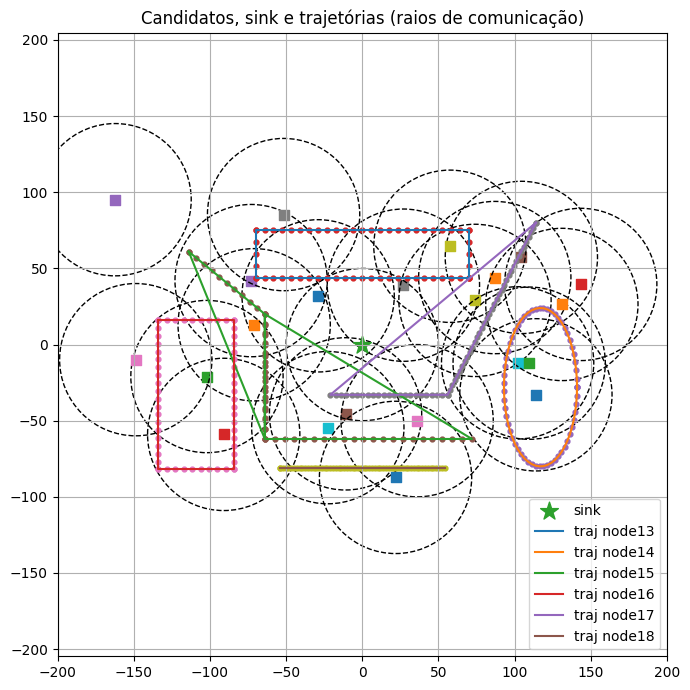

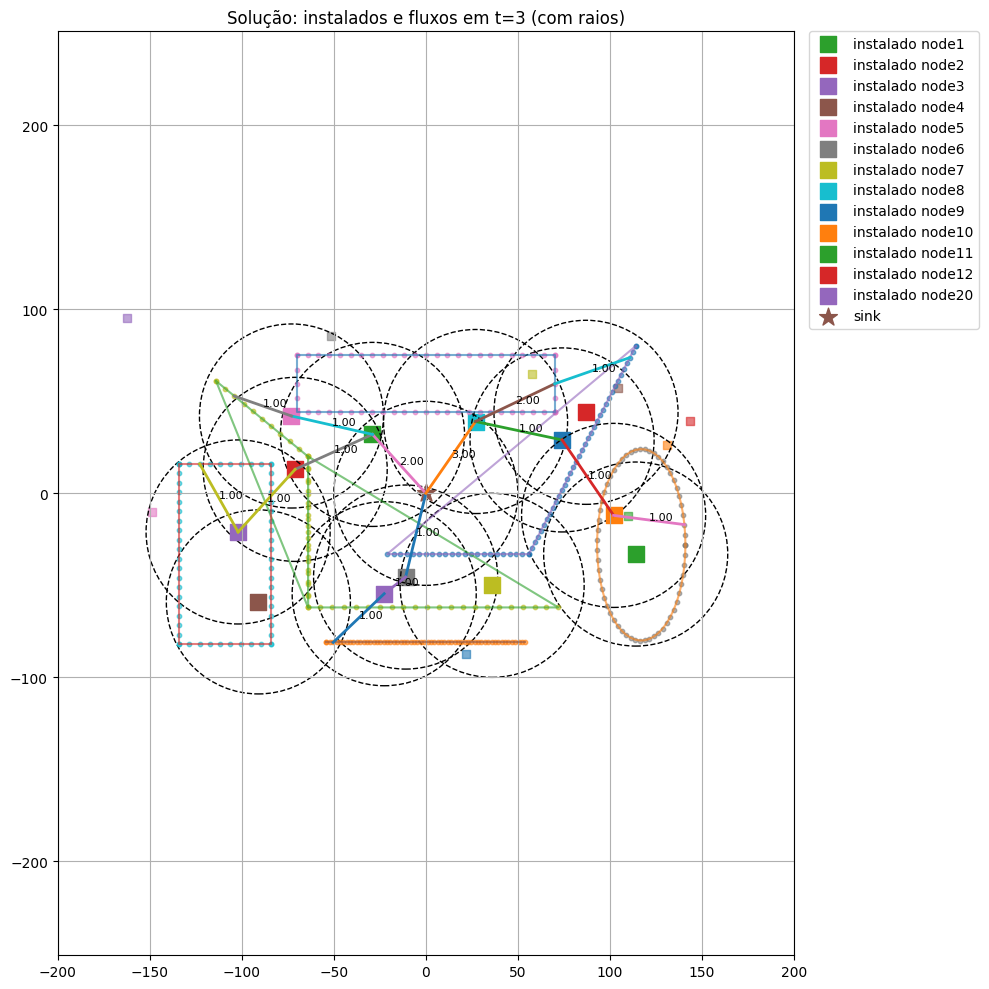

In [13]:
# =====================================================================================
# Pós-processamento e plots
# =====================================================================================

# Conferência de status e extração dos valores
status = mdl.Status
if status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
    raise RuntimeError(f"Modelo não resolveu para ótimo/subótimo. Status Gurobi: {status}")

# Valores das variáveis
y_val = {j: y[j].X for j in F}
installed = [j for j, v in y_val.items() if v > 0.5]

x_val = {(i, j, t): xvar[(i, j, t)].X for t in range(1, T+1) for (i, j) in E_t[t]}
z_val = {(i, j, t): z[(i, j, t)].X for t in range(1, T+1) for (i, j) in E_t[t]}

# Slot para snapshot
t_plot = max(1, min(3, T))

# ---------------------------
# Fig 1: candidatos + trajetórias + raios (sink e candidatos)
# ---------------------------
plt.figure(figsize=(7, 7))
ax1 = plt.gca()

# Candidatos + seus raios de comunicação
for j in F:
    q = q_fixed[j]
    ax1.scatter([q[0]], [q[1]], marker='s', s=60, label=None)
    ax1.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Sink + raio
ax1.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax1.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Trajetórias dos móveis
for name in mob_names:
    traj = np.array([r_mobile(name, t) for t in range(1, T+1)] + [r_mobile(name, 1)])
    ax1.plot(traj[:, 0], traj[:, 1], linestyle='-', label=f"traj {name}")
    ax1.scatter(traj[:, 0], traj[:, 1], marker='o', s=12)

ax1.set_title("Candidatos, sink e trajetórias (raios de comunicação)")
ax1.axis('equal')
ax1.grid(True)
ax1.legend(loc="best")
if region and len(region) == 4:
    ax1.set_xlim(region[0], region[2])
    ax1.set_ylim(region[1], region[3])
plt.tight_layout()
plt.show()

# ---------------------------
# Fig 2: solução (instalados + fluxos em t_plot) + raios (sink e instalados)
# ---------------------------
plt.figure(figsize=(10, 10))
ax2 = plt.gca()

# Todos candidatos (marcadores pequenos)
for j in F:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=40, alpha=0.6, label=None)

# Instalados (marcadores maiores + raio)
for j in installed:
    q = q_fixed[j]
    ax2.scatter([q[0]], [q[1]], marker='s', s=120, label=f"instalado {j[1]}")
    ax2.add_patch(Circle((q[0], q[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Sink + raio
ax2.scatter([q_sink[0]], [q_sink[1]], marker='*', s=180, label="sink")
ax2.add_patch(Circle((q_sink[0], q_sink[1]), R_comm, fill=False, linewidth=1, ls='--'))

# Trajetórias (contexto)
for name in mob_names:
    traj = np.array([r_mobile(name, t) for t in range(1, T+1)] + [r_mobile(name, 1)])
    ax2.plot(traj[:, 0], traj[:, 1], linestyle='-', alpha=0.6, label=None)
    ax2.scatter(traj[:, 0], traj[:, 1], marker='o', s=10, alpha=0.6)

# Fluxos ativos no snapshot t_plot
flows_t = {(i, j): x_val[(i, j, t_plot)] for (i, j) in E_t[t_plot] if x_val[(i, j, t_plot)] > 1e-6}
for (i, j), val in flows_t.items():
    pi, pj = pos_node(i, t_plot), pos_node(j, t_plot)
    ax2.plot([pi[0], pj[0]], [pi[1], pj[1]], linewidth=2)
    cx, cy = (pi[0] + pj[0]) / 2, (pi[1] + pj[1]) / 2
    ax2.text(cx, cy, f"{val:.2f}", fontsize=8)

ax2.set_title(f"Solução: instalados e fluxos em t={t_plot} (com raios)")
ax2.axis('equal')
ax2.grid(True)
ax2.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.0
)
if region and len(region) == 4:
    ax2.set_xlim(region[0], region[2])
    ax2.set_ylim(region[1], region[3])
plt.tight_layout()
plt.show()
